In [1]:
# autoreload
%reload_ext autoreload
%autoreload 2

# Initial processing and visulisation of calcification data

Currently only using my spreadsheet. Initial look at data and methods to fit calcification rates wrt some independent variable.

Some notes, upon reviewing the [PNAS paper](https://www.pnas.org/doi/full/10.1073/pnas.2015265118):

1. Climate models
    - Higher-resolution (0.25º rather than 1º) from CMIP6
    - Factor in ensemble uncertainty rather than simply taking mean
2. Non-linear relationships: a number of papers show a parabolic relationship? This could show increase then decrease in net calcification over time/space
3. Meta summary statistics
    - Total number of studies, total number of datapoints
    - Number of responses per intervention
    - Proportion of locations (by number of surveys, by number of samples)
    - Don’t have reef type consistently between studies, but this *is* a subset of studies. This could be an interesting comparison, but may be getting too complex
    - Quantify different types of studies e.g. ocean acidification and X calcification, N interactive effects etc.
4. Plot decline in NCP as a function of time (if using several timesteps): year in which it switches from production to erosion (perhaps by ocean basin)
5. Reef accretion rates relative to sea level rise
    - PNAS uses mean sea level rise (which alone is pretty catastrophic), but given spatial variability in sea level rise would be interesting to compare spatially to find the biggest losers.
6. What rates are we taking into account? e.g. sediment dissolution rates still assumed to match those measured on lagoon sediments? (unlikely given variability of flushing)
7. “some shallower reefs may actually benefit from rising sea levels, with increasing accommodation space allowing for increased coral vertical growth (40). Indeed, this has been observed in the past (41) during much slower rates of sea level rise. It is unknown whether these possible gains in accretion will outweigh losses due to ocean warming and acidification, but determining when and where this could occur should be an urgent focus for future research” – outside scope of this paper, but interesting!
8. QA questions:
    - “we do not include Halimeda spp. in our model because of the unclear nature of its eventual contribution to reef accretion and because of the larger uncertainty regarding the impacts of ocean acidification and warming on its calcification that was observed during our surveys of the literature.” –Same this time round?
        - Measure species-wise variation in calcification? i.e. these would just be messy plots of response vs variables
    2. “Seawater carbonate chemistry was recalculated in some studies where inconsistencies were found between pH scales”
        - When to recalculate seawater chemistry?
    3. Convert from NBS to Total
        - “Studies using the National Bureau of Standards scale were converted to the total scale (hereafter "pH") using the excel macro CO2sys (51) and method following ref. 52” – I can do this better with cybsyst
    4. “Research examining the effects of ocean acidification were excluded if they did not present standardized measurements of seawater carbonate chemistry that could allow us to accurately determine pH on the total scale (53).”
    5. Extra rates
        - Did I include bioerosion?
        - Sediment production?
7. Environmental variables:
    - Pretty rule of thumb for DHW metric (can perhaps do better): “we assume that if a coral reef community suffers two or more marine heatwaves of a certain DHW extent within one decade, these events will not allow them to recover to their original coral cover.”


In [2]:
### imports
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# custom
import utils, plotting
from cbsyst import helpers as cbh

## Recalculate carbon chemistry from measured values
How valid/universal is this?

In [185]:
fp = "data/Orlando_data.xlsx"

df = pd.read_excel(fp, sheet_name="all_data")
meta_cols = list(df.columns[:11])
### load measured values
measured_df = utils.get_highlighted(fp, sheet_name='all_data', keep_cols=meta_cols)
measured_df = utils.process_df(measured_df, require_results=False)  # process 
measured_df.head()

,extractor,notes,secondary_check,include,authors,doi,year,species_types,taxa,location,...,s_in_sd,n,calcification,calcification_se,calcification_sd,calcification_units,duration,methods,notes+,notes++
0,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,1672531200000000000,Porollithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,1672531200000000000,Porollithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,1672531200000000000,Porollithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,1672531200000000000,Porollithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,1672531200000000000,Lithophyllum cf insipidum,Algae,"Lizard Island, GBR, Australia",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### isolate carbonate chemistry columns
carb_chem_cols = [
    'pco2', 'pco2_se', 'pco2_sd', 'phnbs', 'phnbs_se',
    'phnbs_sd', 'phtot', 'phtot_se', 'phtot_sd', 'ta', 'ta_se', 'ta_sd',
    'dic', 'dic_se', 'dic_sd', 'omegac', 'omegac_se', 'omegac_sd', 'omegaa',
    'omegaa_se', 'omegaa_sd', 'co3', 'co3_se', 'co3_sd', 'hco3', 'hco3_se',
    'hco3_sd', 't_in', 't_in_se', 't_in_sd',
    's_in', 's_in_se', 's_in_sd'
]
carb_df = measured_df[carb_chem_cols]
carb_df = carb_df.dropna(axis=0, inplace=False, how='all')     # TODO: this shouldn't be necessary once worked out why first rows from highlight function are nan

### convert nbs values to total scale using cbsyst     # TODO: implement uncertainty propagation
carb_df['phtot'] = carb_df.apply(
    lambda row: cbh.pH_scale_converter(
        pH=row['phnbs'], scale='NBS', Temp=row['t_in'], Sal=row['s_in']
    ).get('pHtot', None) if pd.notna(row['phnbs']) and pd.notna(row['t_in']) and pd.notna(row['s_in'])
    else row['phtot'],
    axis=1
)

In [ ]:
out_values = utils.read_yaml("data/mapping.yaml")['carbonate_chemistry_params']

# apply function row-wise
carb_df[out_values] = carb_df.apply(calculate_carb_chem, axis=1).apply(pd.Series)

# On to other things

In [ ]:
df = pd.read_excel(fp, sheet_name="all_data")

# # Default selection values
# default_selection = {'Extractor': 'Orlando', 'Include': 'yes'}

# # Apply selection
# for key, value in default_selection.items():
#     df = df[df[key] == value]
# df['Calcification units'].unique()

In [ ]:
### load data and clean
df = pd.read_excel(fp, sheet_name="all_data")

df = utils.process_df(df)
### summary statistics
# count number of entries with pH Total values vs pH NBS
print('ALL UNITS')
print('Number of studies:', df.doi.nunique())
print('Number of samples:', int(df.n.sum()))
print('Number of datapoints (any unit):', df.shape[0])
print("# pH Total scale entries:", df.ph_total.notna().sum(), "\n# pH NBS scale entries:", df.ph_nbs.notna().sum())

print('\nABSOLUTE UNITS ONLY')
df = df[df.calcification_units.str.contains('CaCO3', na=False)] # keep only rows containing 'CaCO3 in the calcification_unit column
print('Number of studies:', df.doi.nunique())
print('Number of samples:', int(df.n.sum()))
print('Number of CaCO3 datapoints:', df.shape[0])
print("# pH Total scale entries:", df.ph_total.notna().sum(), "\n# pH NBS scale entries:", df.ph_nbs.notna().sum())
df.head(n=2)

ALL UNITS
Number of studies: 35
Number of samples: 5289
Number of datapoints (any unit): 2904
# pH Total scale entries: 2626 
# pH NBS scale entries: 272

ABSOLUTE UNITS ONLY
Number of studies: 16
Number of samples: 2437
Number of CaCO3 datapoints: 1770
# pH Total scale entries: 1577 
# pH NBS scale entries: 187


,extractor,notes,secondary_check,include,authors,doi,year,species_types,taxa,location,...,salinity_sd_ppt,n,calcification,calcification_se,calcification_sd,calcification_units,duration,methods,notes+,notes++
99,Orlando,Second murrayensis cultured at different pco2s,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.04,3,20.8,NaN,0.6,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN
100,Orlando,NaN,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.04,3,21.3,NaN,2.9,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN


In [51]:
import unicodedata
print(len(df.calcification_units.unique()))

df.calcification_units.value_counts()
# print(len(df.map(lambda x: unicodedata.normalize("NFKC", str(x)).replace("μ", "u") if isinstance(x, str) else x).unit.unique()))

10


calcification_units
mg CaCO3 cm-2 d-1       1198
mgCaCO3 cm-2day-1        200
mgCaCO3 mg-1day-1        143
nmol CaCO3 mg-1day-1      96
µmolCaCO3 cm-2hr-1        64
gCaCO3 g-1day-1           36
nmolCaCO3 cm-2hr-1        12
µmolCaCO3 cm-2day-1       11
gCaCO3 cm-2day-1           6
mgCaCO3 gFW-1hr-1          4
Name: count, dtype: int64

In [52]:
### map between units
map_dict = utils.read_yaml("data/mapping.yaml")["unit_map"]
inverted_map = {val: key for key, values in map_dict.items() for val in values}

df['unit'] = df['calcification_units'].map(inverted_map)
df['unit'].value_counts()
print(df['unit'].value_counts())
print('\nNumber of unmapped unit entries:', df['unit'].isna().sum())

unit
mgCaCO3 cm-2d-1       1398
mgCaCO3 mg-1d-1        143
nmolCaCO3 mg-1d-1       96
gCaCO3 g-1d-1           36
nmolCaCO3 cm-2hr-1      12
gCaCO3 cm-2-1d-1         6
mgCaCO3 g-1hr-1          4
Name: count, dtype: int64

Number of unmapped unit entries: 75


In [5]:
### assign measurement type
conditions = [
    df['unit'].str.contains('CaCO3', na=False),
    df['unit'].str.contains('delta', na=False)
]
choices = ['CaCO3', 'delta']
df['calcification_measurement_type'] = np.select(conditions, choices, default='mass')
df['calcification_measurement_type'].value_counts()

calcification_measurement_type
CaCO3    1770
Name: count, dtype: int64

In [6]:
### get first row of each unique unit for testing
unit_df = pd.DataFrame(df.drop_duplicates(subset=['unit'])[['unit', 'calcification']], columns=['unit','calcification'])
unit_df.dropna(inplace=True)
unit_df

,unit,calcification
99,µmolCaCO3 cm-2d-1,20.800000
124,nmolCaCO3 cm-2hr-1,191.000000
140,mgCaCO3 g-1hr-1,0.236827
281,gCaCO3 g-1d-1,0.153326
413,mgCaCO3 mg-1d-1,1.158301
1132,mgCaCO3 cm-2d-1,0.891509
1152,gCaCO3 cm-2-1d-1,0.003500
1615,µmolCaCO3 cm-2hr-1,0.318000
5340,nmolCaCO3 mg-1d-1,43.000000


In [271]:
unit_df

,unit,calcification
99,µmolCaCO3 cm-2d-1,20.800000
124,nmolCaCO3 cm-2hr-1,191.000000
140,mgCaCO3 g-1hr-1,0.236827
281,gCaCO3 g-1d-1,0.153326
413,mgCaCO3 mg-1d-1,1.158301
1132,mgCaCO3 cm-2d-1,0.891509
1152,gCaCO3 cm-2-1d-1,0.003500
1615,µmolCaCO3 cm-2hr-1,0.318000
5340,nmolCaCO3 mg-1d-1,43.000000


In [7]:
### TODO: fix conversion between units
# TODO: this is such a huge range!! Need to do some data QA
df['corr_calcification'] = unit_df.apply(lambda x: utils.rate_conversion(x['calcification'], x['unit']), axis=1)
df["new_unit"] = df["unit"].apply(utils.unit_name_conversion)
df["new_unit"].value_counts()

new_unit
gCaCO3 m-2d-1    1491
gCaCO3 g-1d-1     279
Name: count, dtype: int64

In [8]:
# test_df = df[df['doi'] == '10.3389/fmars.2020.581160']
test_df = df[df['doi'] == '10.1038/s42003-022-04353-1']
test_df[['calcification', 'calcification_units']]

,calcification,calcification_units
1615,0.318000,µmolCaCO3 cm-2hr-1
1616,0.452000,µmolCaCO3 cm-2hr-1
1617,0.389000,µmolCaCO3 cm-2hr-1
1618,0.293000,µmolCaCO3 cm-2hr-1
1619,0.438035,µmolCaCO3 cm-2hr-1
...,...,...
1674,-0.027881,µmolCaCO3 cm-2hr-1
1675,-0.109627,µmolCaCO3 cm-2hr-1
1676,-0.056472,µmolCaCO3 cm-2hr-1
1677,-0.209112,µmolCaCO3 cm-2hr-1


In [53]:
(test_df['calcification']*1e-6*1e4*24*utils.MOLAR_MASS_CACO3)

1615     7.638632
1616    10.857427
1617     9.344113
1618     7.038111
1619    10.521979
          ...    
1674    -0.669733
1675    -2.633323
1676    -1.356506
1677    -5.023057
1678    -2.882611
Name: calcification, Length: 64, dtype: float64

In [54]:
test_df.apply(lambda x: utils.rate_conversion(x['calcification'], x['calcification_units']), axis=1)

1615    7.638632e+06
1616    1.085743e+07
1617    9.344113e+06
1618    7.038111e+06
1619    1.052198e+07
            ...     
1674   -6.697332e+05
1675   -2.633323e+06
1676   -1.356506e+06
1677   -5.023057e+06
1678   -2.882611e+06
Length: 64, dtype: float64

In [55]:
df.doi.unique()

array(['10.1016/j.chemgeo.2018.09.004', '10.1007/s00338-020-01995-7',
       '10.1007/s00338-019-01775-y', '10.1098/rsos.220760',
       '10.1016/j.ecochg.2021.100016', '10.1111/gcb.14998',
       '10.1186/s40168-023-01653-4', '10.1038/s42003-022-04353-1',
       '10.3389/fmars.2020.581160', '10.1016/j.jembe.2016.10.002',
       '10.1016/j.marenvres.2023.106150', '10.1016/j.jembe.2019.151225',
       '10.1098/rsos.170683', '10.1111/gcb.13481',
       '10.1007/s00227-016-2986-8', '10.1029/2020JG005726'], dtype=object)

In [56]:
subset_df = df[df.doi != '10.1007/s00338-020-01995-7']
subset_df = subset_df[subset_df.doi != '10.1029/2020JG005726']

In [ ]:
subset_df = df
### visualise ranges of calcification values and which studies to blame

import plotly.graph_objects as go

def plot_stacked_hist_interactive(df: pd.DataFrame, unit: str, title: str, doi_list: list, color_map: dict) -> None:
    """
    Plot an interactive stacked histogram of calcification values for a given unit condition.
    
    Args:
        df (pd.DataFrame): DataFrame containing calcification data.
        unit (str): Value to plot.
        title (str): Plot title.
        doi_list (list): List of DOIs to include in the plot.
        color_map (dict): Dictionary mapping DOI to color.
    
    Returns:
        None    
    """
    filtered_df = df[df["new_unit"] == unit]
    
    # Initialize figure
    fig = go.Figure()

    for doi in doi_list:
        doi_data = filtered_df[filtered_df["doi"] == doi]["corr_calcification"]
        fig.add_trace(go.Histogram(
            x=doi_data,
            name=doi,
            marker=dict(color=color_map.get(doi, "#999999")),  # Fallback color if DOI not in color_map
            opacity=0.75,
            customdata=[doi] * len(doi_data),  # Add DOI info to hover
            hovertemplate="DOI: %{customdata}<br>Calcification: %{x}<br>Frequency: %{y}<extra></extra>"
        ))
    
    fig.update_layout(
        barmode='stack',
        title=title,
        xaxis_title='Calcification',
        yaxis_title='Frequency',
        hovermode='x'
    )
    
    fig.show()



doi_list = subset_df["doi"].unique()
doi_colors = {doi: plt.cm.turbo(i / len(doi_list)) for i, doi in enumerate(doi_list)}
plot_stacked_hist_interactive(df, "gCaCO3 m-2d-1", "Specific Area Measurements" , doi_list, doi_colors)

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


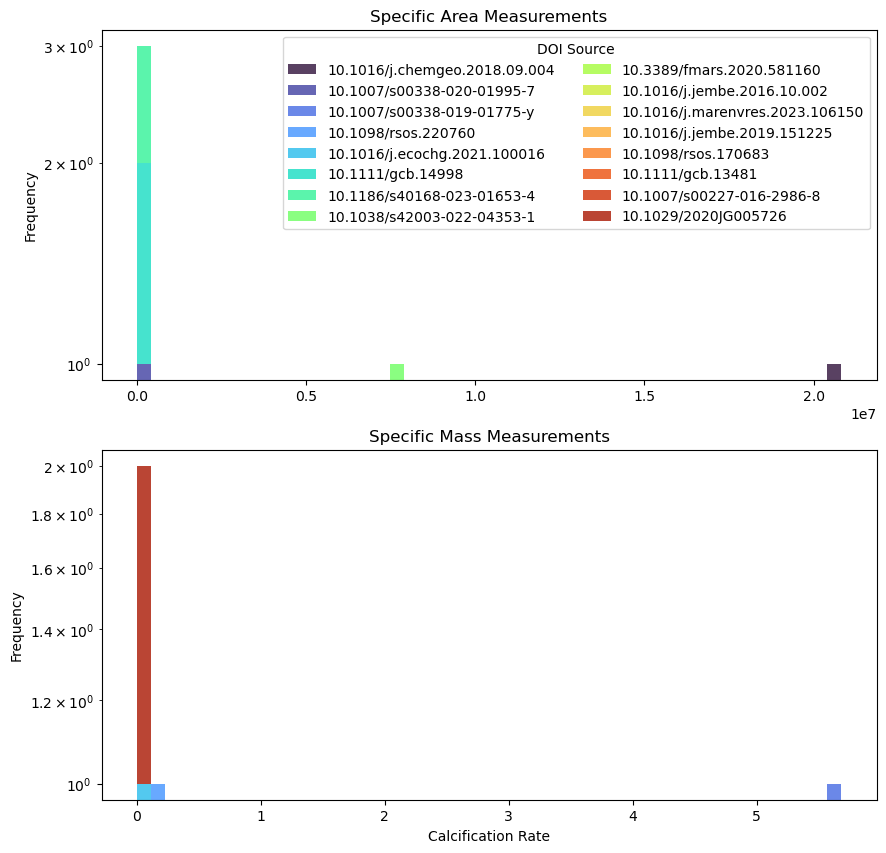

In [291]:
subset_df = df
### visualise ranges of calcification values and which studies to blame

doi_list = subset_df["doi"].unique()
doi_colors = {doi: plt.cm.turbo(i / len(doi_list)) for i, doi in enumerate(doi_list)}
fig, (ax_area, ax_mass) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Plot for area-based measurements
plotting.plot_stacked_hist(subset_df, ax_area, "gCaCO3 m-2d-1", "Specific Area Measurements", doi_list, doi_colors)

# Plot for mass-based measurements
plotting.plot_stacked_hist(subset_df, ax_mass, "gCaCO3 g-1d-1", "Specific Mass Measurements", doi_list, doi_colors)

# Formatting
ax_mass.set_xlabel("Calcification Rate")
ax_mass.set_ylabel("Frequency")
ax_area.legend(title="DOI Source", loc="upper right", ncols=2)

[ax.set_yscale("log") for ax in [ax_area, ax_mass]]
# ax_area.set_xlim(0,3)
plt.show()


/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_15596/1642976480.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  [ax.set_yscale("log") for ax in [ax_area, ax_mass]]


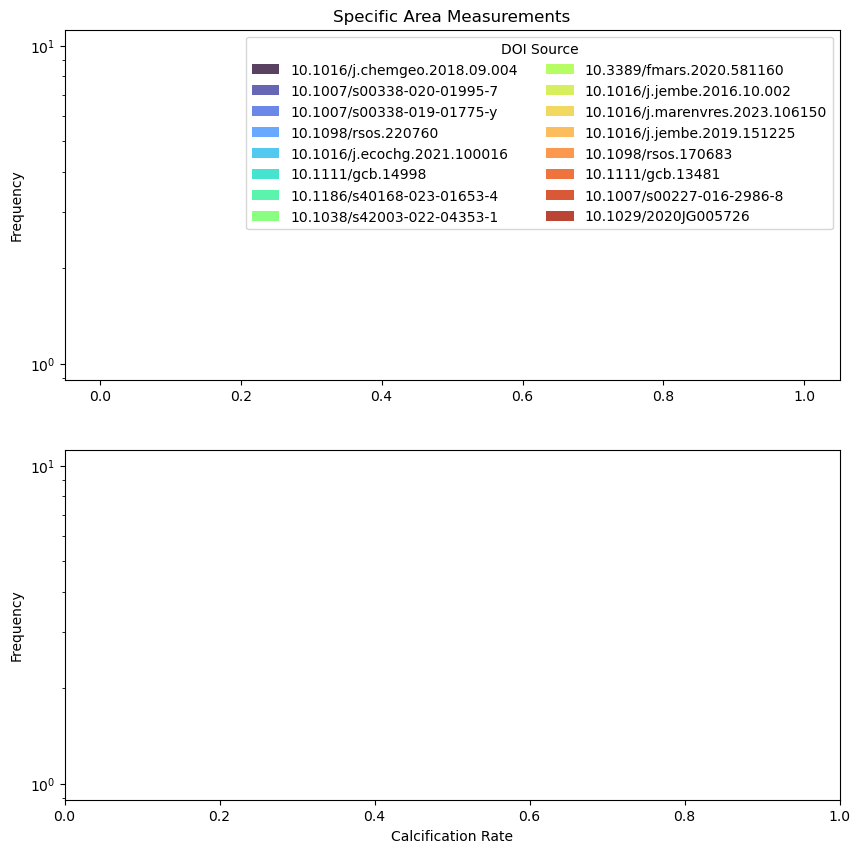

In [ ]:
### visualise ranges of calcification values and which studies to blame

doi_list = df["doi"].unique()
doi_colors = {doi: plt.cm.turbo(i / len(doi_list)) for i, doi in enumerate(doi_list)}
fig, (ax_area, ax_mass) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Plot for area-based measurements
plotting.generic_plot_stacked_hist(df, ax_area, filter_col_name="unit", filter_col_val="gCaCO3 m-2d-1", group_col_name="doi", response_col_name="calcification", group_values_list=doi_list, color_map=doi_colors, title="Specific Area Measurements")

# Plot for mass-based measurements
plotting.generic_plot_stacked_hist(df, ax_mass, filter_col_name="unit", filter_col_val="gCaCO3 g-1d-1", group_col_name="doi", response_col_name="calcification", group_values_list=doi_list, color_map=doi_colors, title="Specific Area Measurements")

# plotting.generic_plot_stacked_hist(df, ax_mass, "gCaCO3 g-1d-1", "Specific Mass Measurements", doi_list, doi_colors)

# Formatting
ax_mass.set_xlabel("Calcification Rate")
ax_mass.set_ylabel("Frequency")
ax_area.legend(title="DOI Source", loc="upper right", ncols=2)

[ax.set_yscale("log") for ax in [ax_area, ax_mass]]

plt.show()


In [ ]:
### visualise ranges of calcification values and which studies to blame

doi_list = df["doi"].unique()
doi_colors = {doi: plt.cm.turbo(i / len(doi_list)) for i, doi in enumerate(doi_list)}
fig, (ax_area, ax_mass) = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Plot for area-based measurements
plotting.plot_stacked_hist(df, ax_area, "gCaCO3 m-2d-1", "Specific Area Measurements", doi_list, doi_colors)

# Plot for mass-based measurements
plotting.plot_stacked_hist(df, ax_mass, "gCaCO3 g-1d-1", "Specific Mass Measurements", doi_list, doi_colors)

# Formatting
ax_mass.set_xlabel("Calcification Rate")
ax_mass.set_ylabel("Frequency")
ax_area.legend(title="DOI Source", loc="upper right", ncols=2)

[ax.set_yscale("log") for ax in [ax_area, ax_mass]]

plt.show()


100%|██████████| 27/27 [00:00<00:00, 40.79it/s]


In [ ]:
# parameter
param = 'min'

data_xa['param_combination']['Temperature'].min()

<xarray.DataArray 'Temperature' ()> Size: 8B
array(21.1)

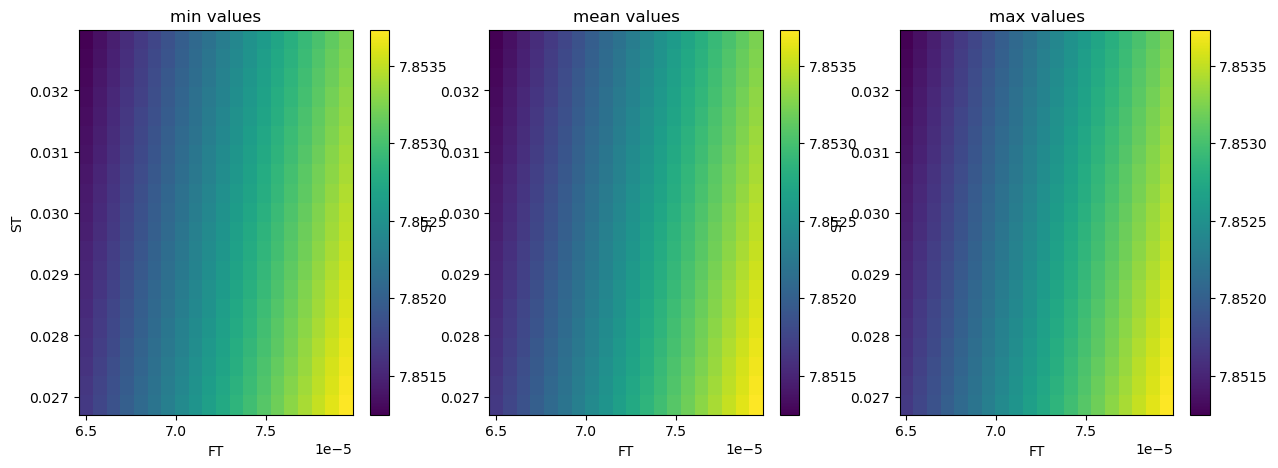

In [ ]:
# plot the sensitivity analysis: plot the array at min of all variables, max of all variables, and mean of all variables in separate subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, var) in enumerate(zip(axs, ["min", "mean", "max"])):
    data_xa.mean(dim="param_combination").plot(ax=ax, cmap="viridis", add_colorbar=True)
    ax.set_title(f"{var} values")
    ax.set_xlabel("FT")
    ax.set_ylabel("ST")
    

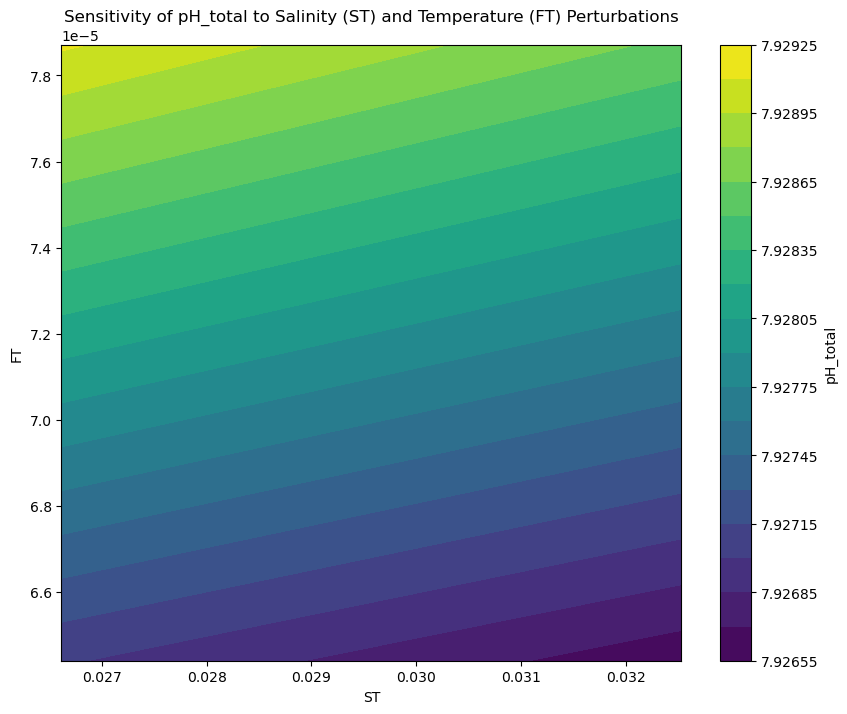

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D pivot table for pH_Total with 'ST' and 'FT'
pivot_df = df_results.pivot_table(values='pH_Total', index='FT', columns='ST')

# Now we can plot the contour
plt.figure(figsize=(10, 8))
contour = plt.contourf(pivot_df.columns, pivot_df.index, pivot_df.values, 20, cmap='viridis')
plt.colorbar(contour, label='pH_total')  # Add color bar to show pH_total scale
plt.xlabel('ST')
plt.ylabel('FT')
plt.title('Sensitivity of pH_total to Salinity (ST) and Temperature (FT) Perturbations')

plt.show()

In [ ]:
df = df.merge(nbs_df[['pH_Total']], left_index=True, right_index=True, how='left')  # insert new pH_Total column into main df values

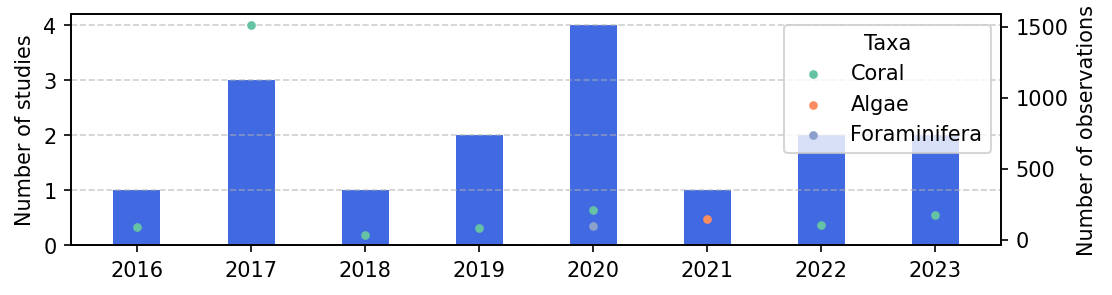

In [ ]:
### plot temporal distribution of studies, breakdown by species
# create figure
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=150)

# drop na from year columns
dates_df = df.dropna(subset=["year"])

# count occurrences of year of each doi
year_counts = df.groupby('year')['doi'].nunique()

ax.bar(year_counts.index, year_counts.values, color='royalblue', width=150)
ax.set_ylabel("Number of studies")
ax.grid(axis='y', linestyle='--', alpha=0.6)

# group df by taxa
taxa_df_grouped = df.groupby(['taxa', 'year'])

# sum total n for each unique taxa and by year
taxa_counts = taxa_df_grouped['n'].sum()

### plot number of observations each year, by 
unique_taxa = df['taxa'].unique()
n_ax = ax.twinx()
taxa_palette = sns.color_palette("Set2", len(unique_taxa))
taxa_color_map = dict(zip(unique_taxa, taxa_palette))
for taxa in unique_taxa:
    taxa_data = taxa_counts[taxa_counts.index.get_level_values('taxa') == taxa]
    n_ax.scatter(taxa_data.index.get_level_values('year'), taxa_data.values, color=taxa_color_map[taxa], alpha=1, s=10, label=taxa)

n_ax.set_ylabel("Number of observations")
n_ax.legend(title="Taxa", loc='upper right')

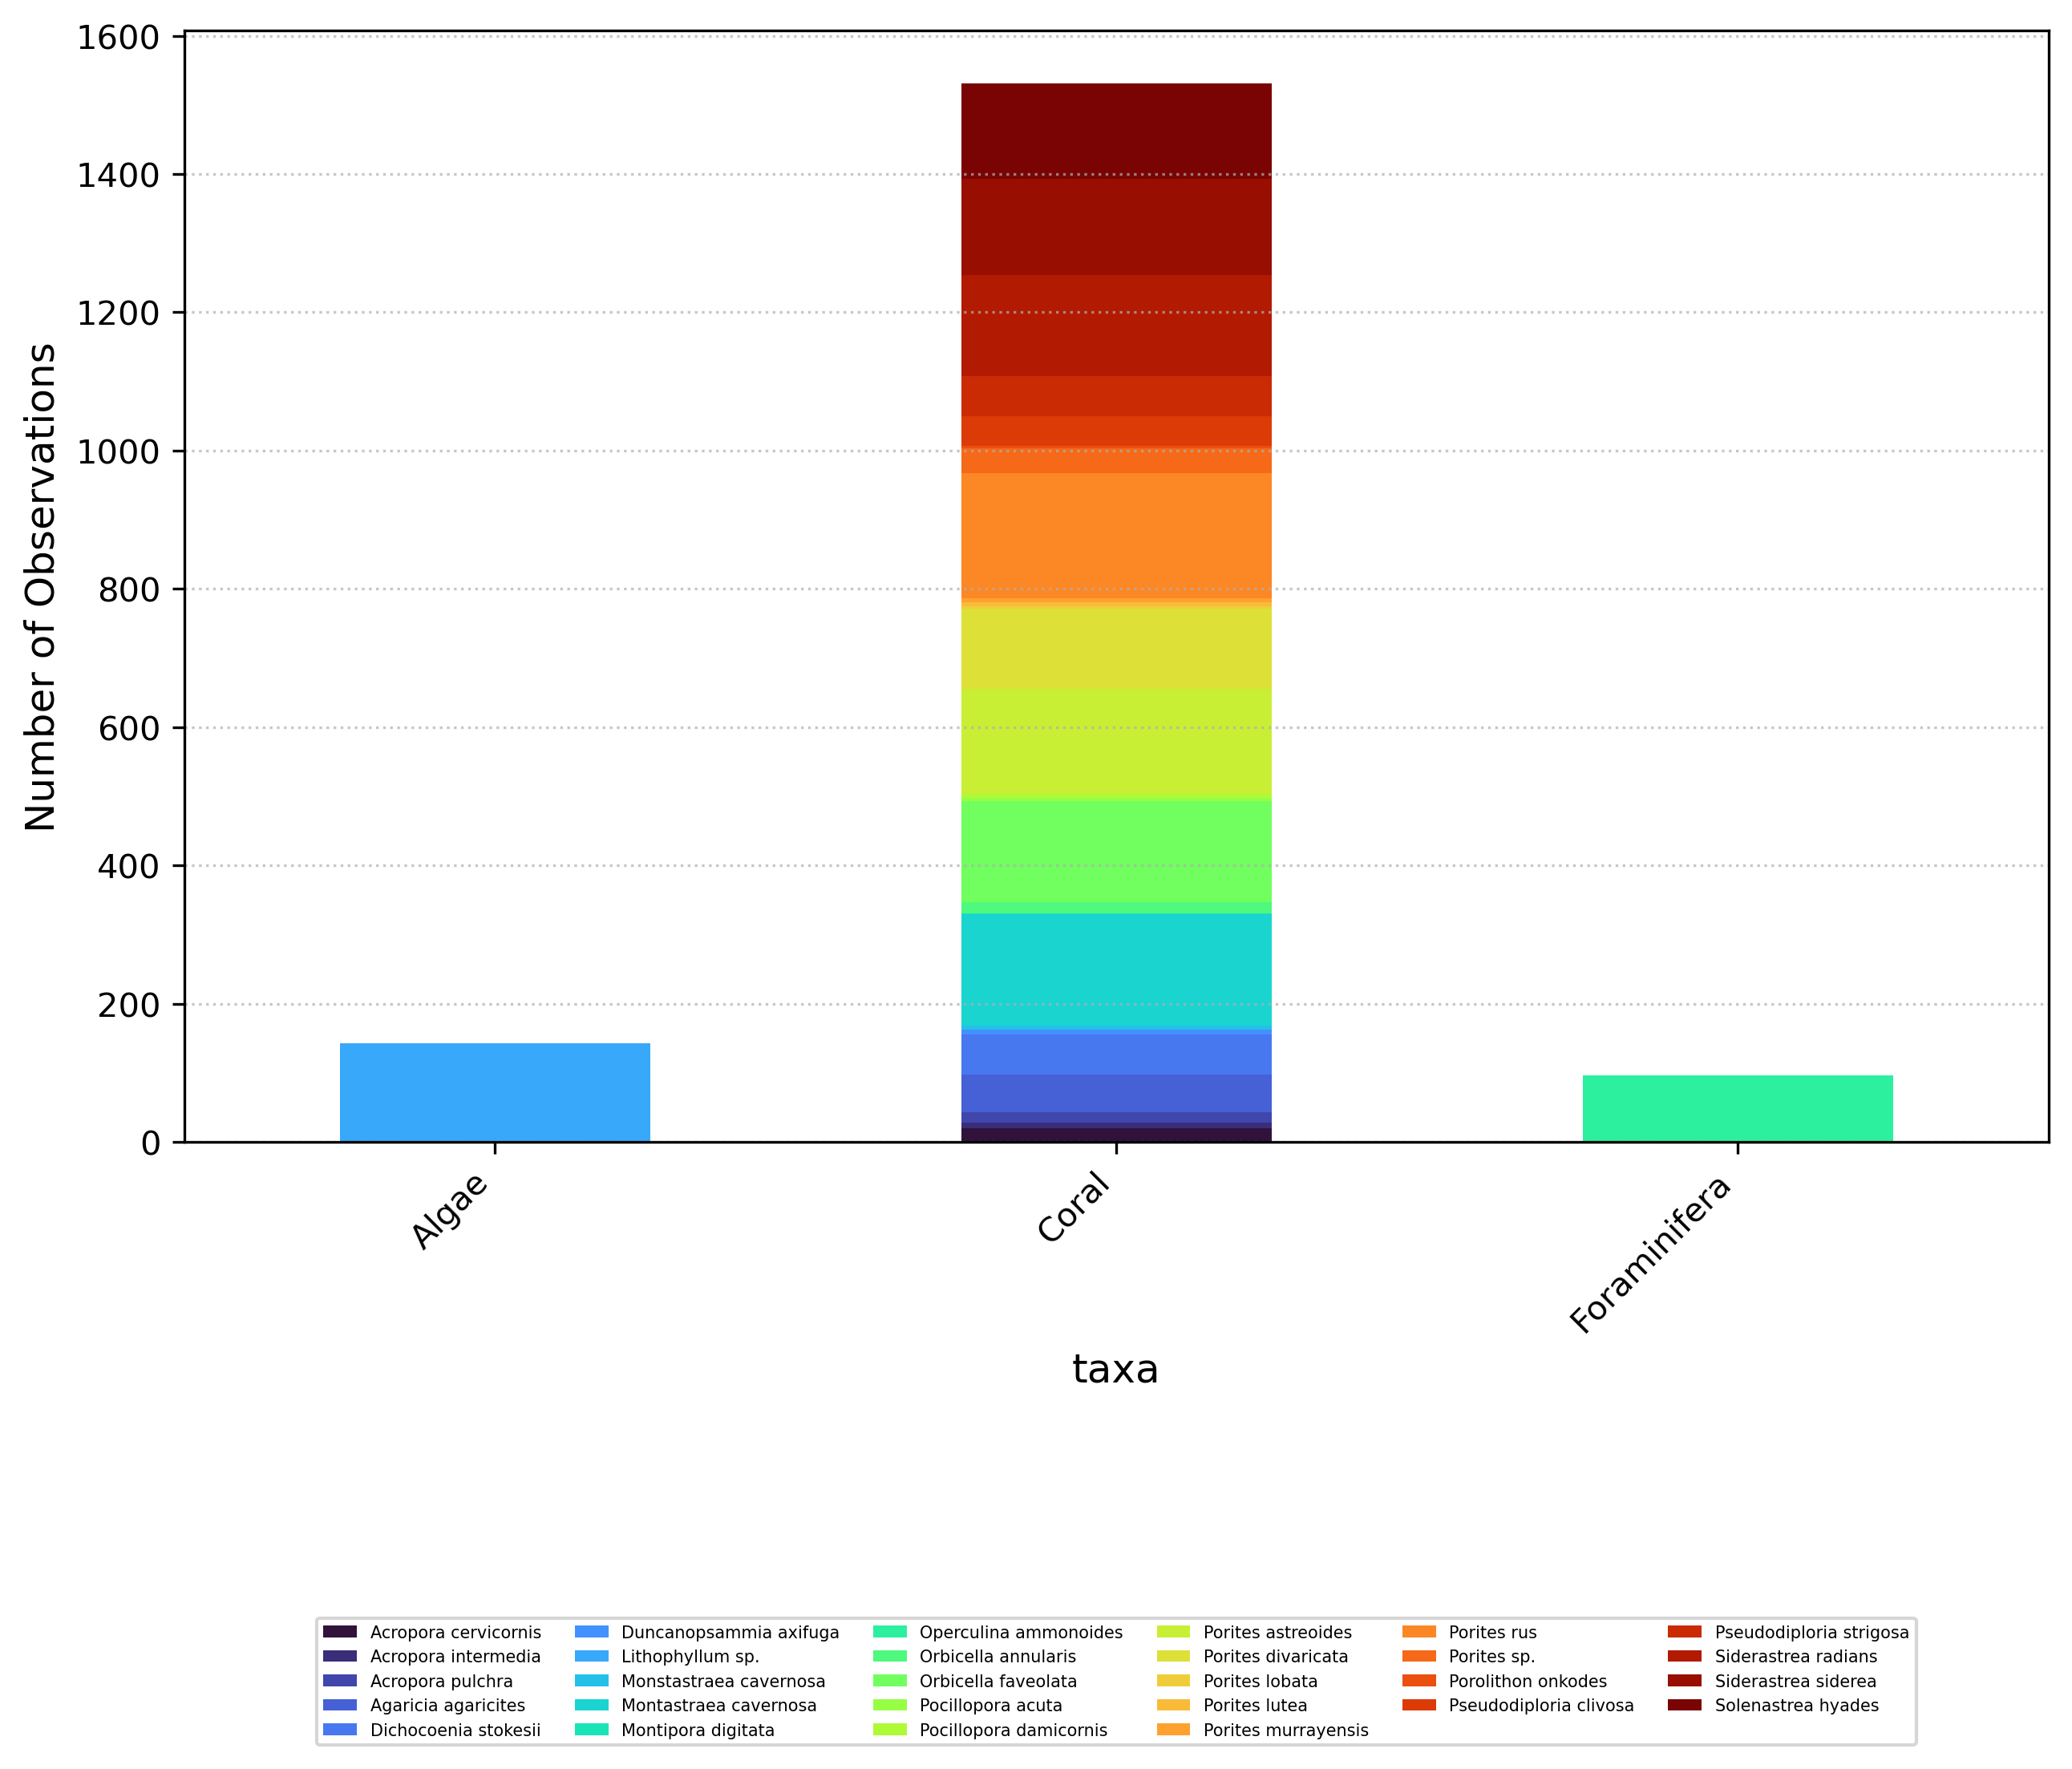

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Aggregate counts of species types within each taxa
species_counts = df.groupby(['taxa', 'species_types']).size().unstack(fill_value=np.nan)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
species_counts.plot(kind='bar', stacked=True, ax=ax, colormap='turbo')

# Formatting
ax.set_xlabel("taxa", fontsize=12)
ax.set_ylabel("Number of Observations", fontsize=12)
ax.legend(fontsize=5, bbox_to_anchor=(0.5, -0.55), ncols=6, loc='lower center')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle=':', alpha=0.7)

plt.show()

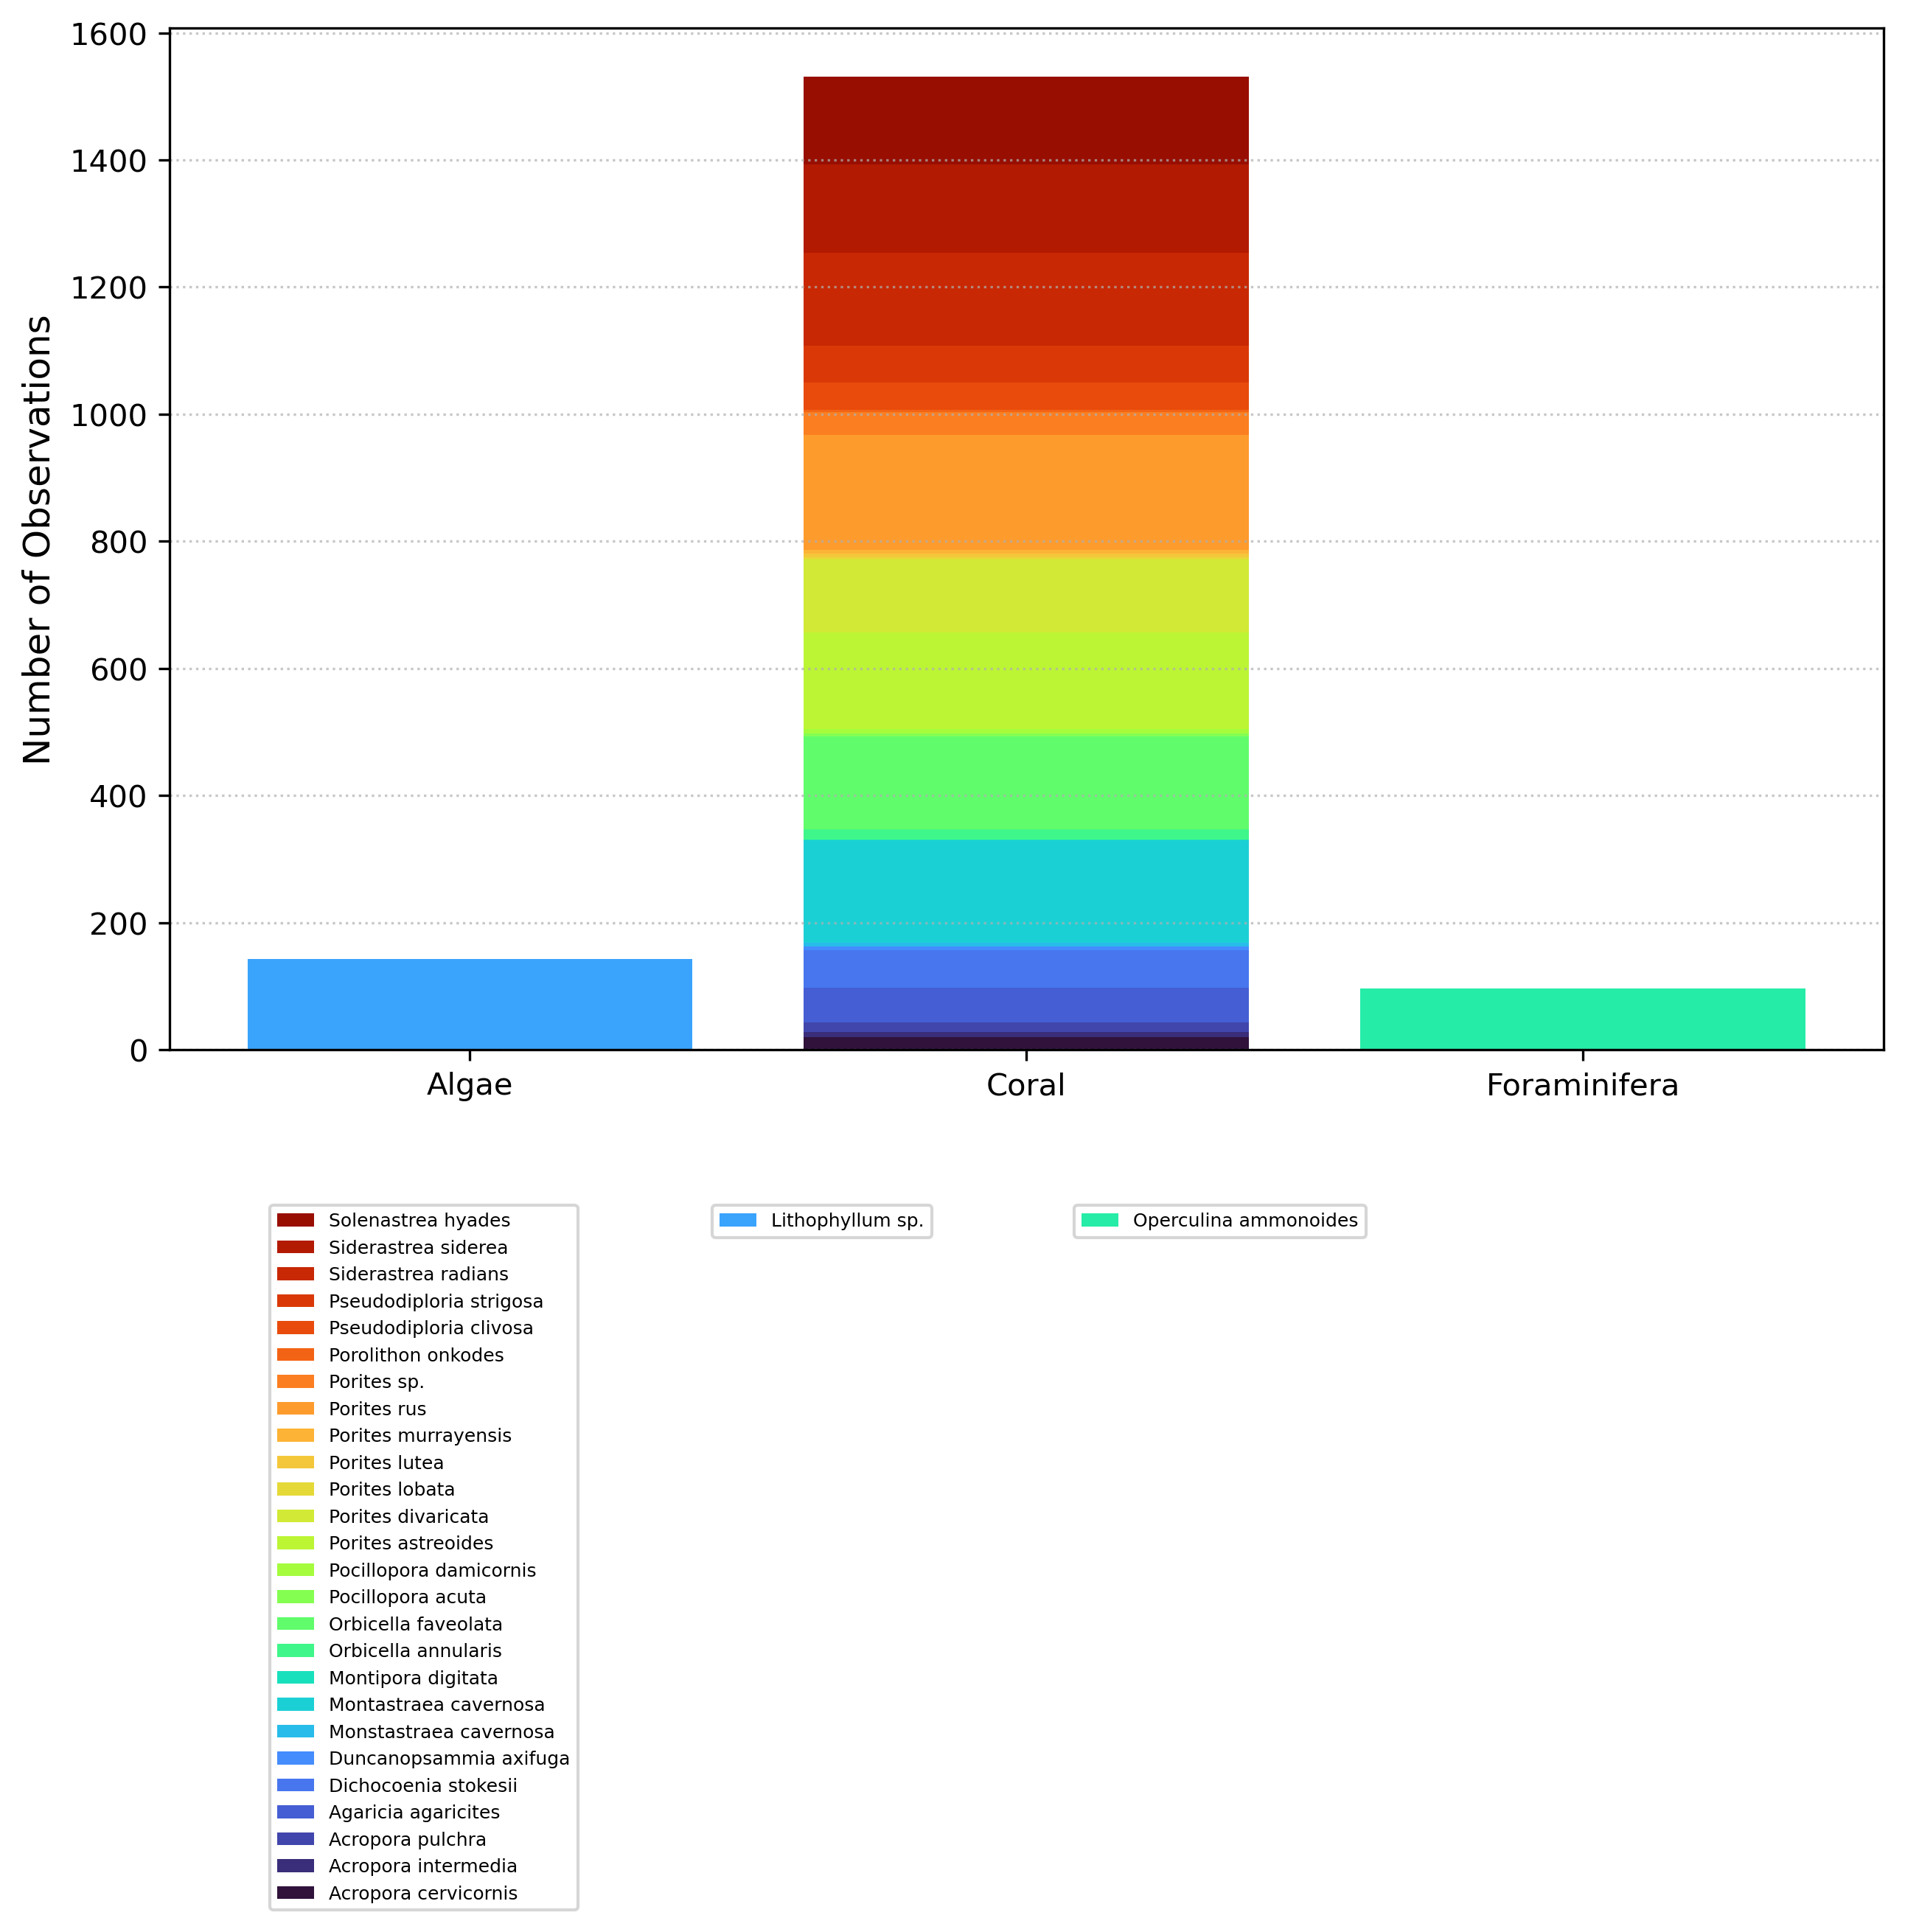

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

species_counts = df.groupby(['taxa', 'species_types']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

colormap = plt.get_cmap('turbo')
unique_species_types = species_counts.columns
colors = {species: colormap(i / len(unique_species_types)) for i, species in enumerate(unique_species_types)}

# Plot each taxon separately
bottom = np.zeros(len(species_counts))
legend_handles = {}

for species in unique_species_types:
    values = species_counts[species].values
    if np.any(values):  # Only plot species that have data
        bars = ax.bar(species_counts.index, values, bottom=bottom, color=colors[species], label=species)
        bottom += values

        # Store legend handles for only the species present in each taxon
        for taxon, bar, value in zip(species_counts.index, bars, values):
            if value > 0:  # Only add species that actually appear
                if taxon not in legend_handles:
                    legend_handles[taxon] = []
                legend_handles[taxon].append((bar, species))

ax.set_ylabel("Number of Observations", fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle=':', alpha=0.7)

# add separate legends for each taxa (only relevant species types)  TODO: could put legends within plot
for i, (taxon, handles) in enumerate(legend_handles.items()):
    ax.figure.legend(
        [h[0] for h in handles[::-1]], [h[1] for h in handles[::-1]],
        # title=f"Species Types in {taxon}",
        fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0), ncol=1
    )

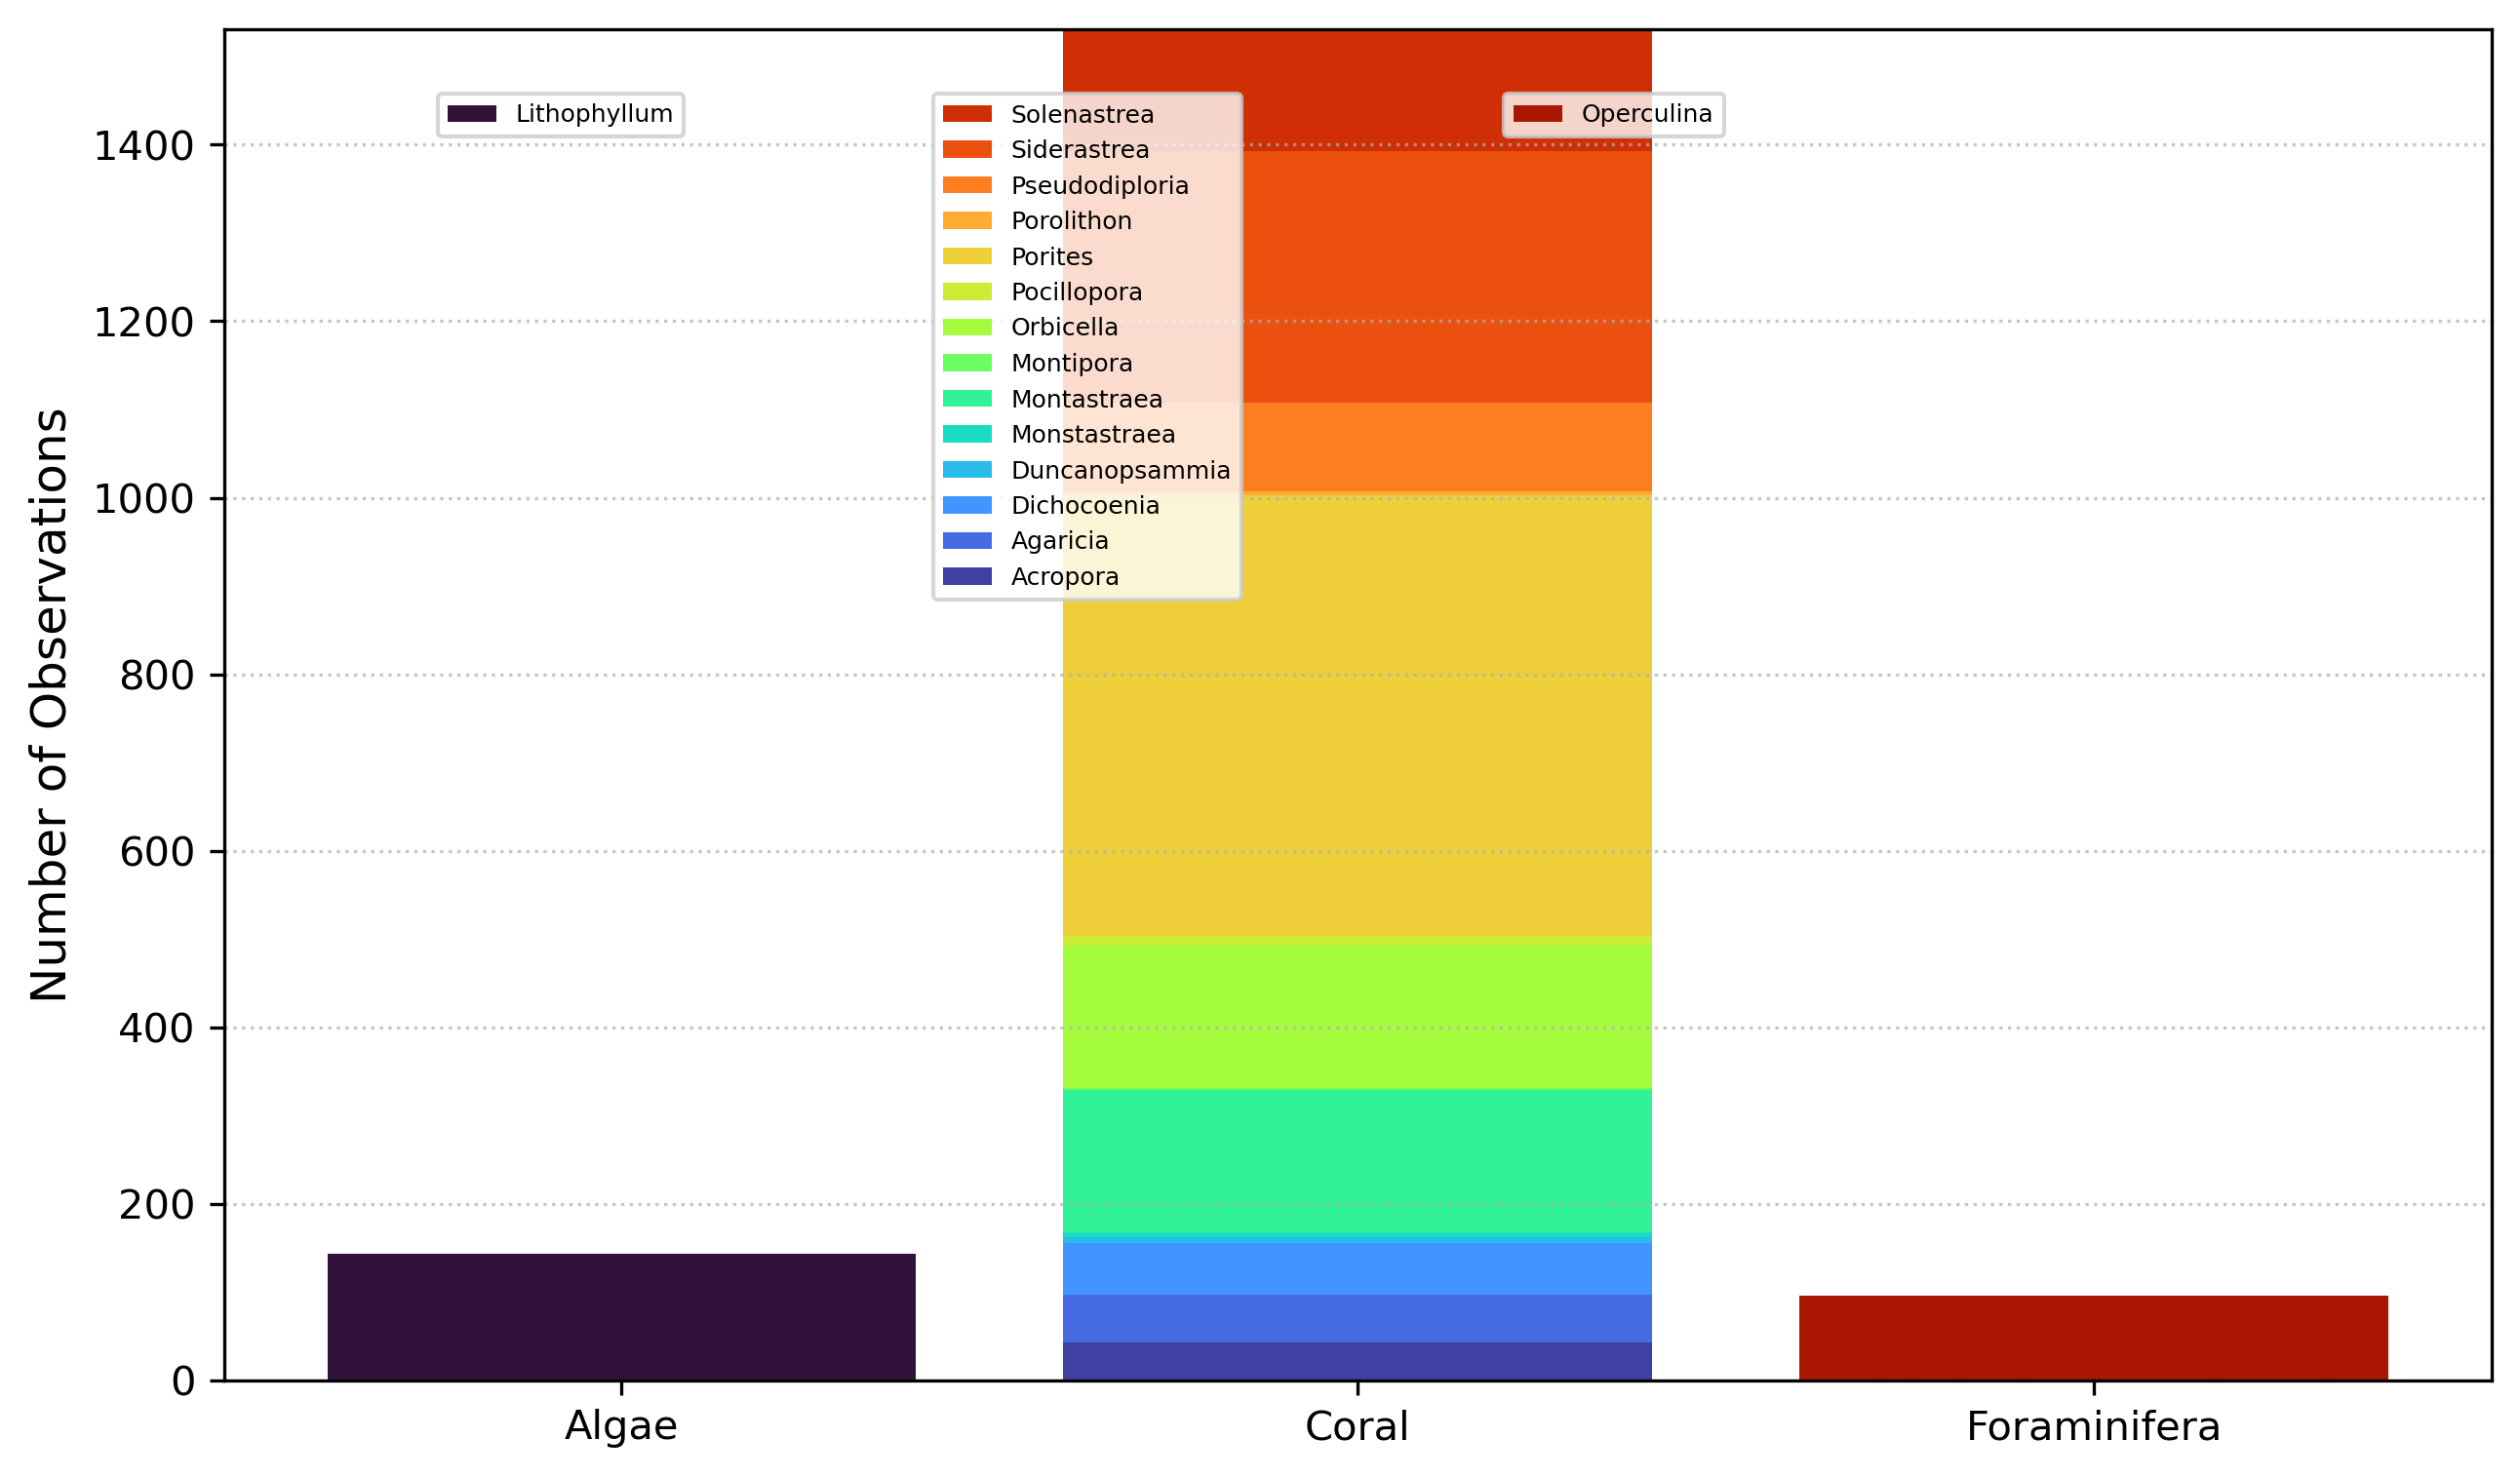

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# aggregate counts of species types within each genus
df['genus'] = df['species_types'].str.split(' ', expand=True)[0]
genus_counts = df.groupby(['taxa', 'genus']).size().unstack(fill_value=0)
# order by taxon for smooth colours later
first_nonzero = (genus_counts != 0).values.argmax(axis=0)   # find the first nonzero row index for each column
genus_counts = genus_counts.iloc[:, np.argsort(first_nonzero)]  # sort columns based on the first occurrence of nonzero values

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

colormap = plt.get_cmap('turbo')
unique_genera = genus_counts.columns
colors = {genus: colormap(i / len(unique_genera)) for i, genus in enumerate(unique_genera)}

### plot each taxon separately
bottom = np.zeros(len(genus_counts))
legend_handles = {}

for genus in unique_genera:
    values = genus_counts[genus].values
    if np.any(values):  # only plot genera with data
        bars = ax.bar(genus_counts.index, values, bottom=bottom, color=colors[genus], label=genus)
        bottom += values

        for taxon, bar, value in zip(genus_counts.index, bars, values):
            if value > 0:  # only add genera that actually appear
                if taxon not in legend_handles:
                    legend_handles[taxon] = []
                legend_handles[taxon].append((bar, genus))

ax.set_ylabel("Number of Observations", fontsize=12)
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle=':', alpha=0.7)


# add separate legends for each taxa (only relevant genera)
for i, (taxon, handles) in enumerate(legend_handles.items()):
    grad_handles = handles[::-1]  # reverse order of handles
    # if taxon != 'Coral':
    #     ax.figure.legend(
    #         [h[0] for h in grad_handles], [h[1] for h in grad_handles],
    #         fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0.85), ncol=1
    #     )
    # else:
    ax.figure.legend(
        [h[0] for h in grad_handles], [h[1] for h in grad_handles],
        fontsize=6, loc='upper center', bbox_to_anchor=((0.24 + i * 0.18), 0.85), ncol=1
    )
        

plt.show()

KeyError: "['pH_Total', 'se_scaled'] not in index"

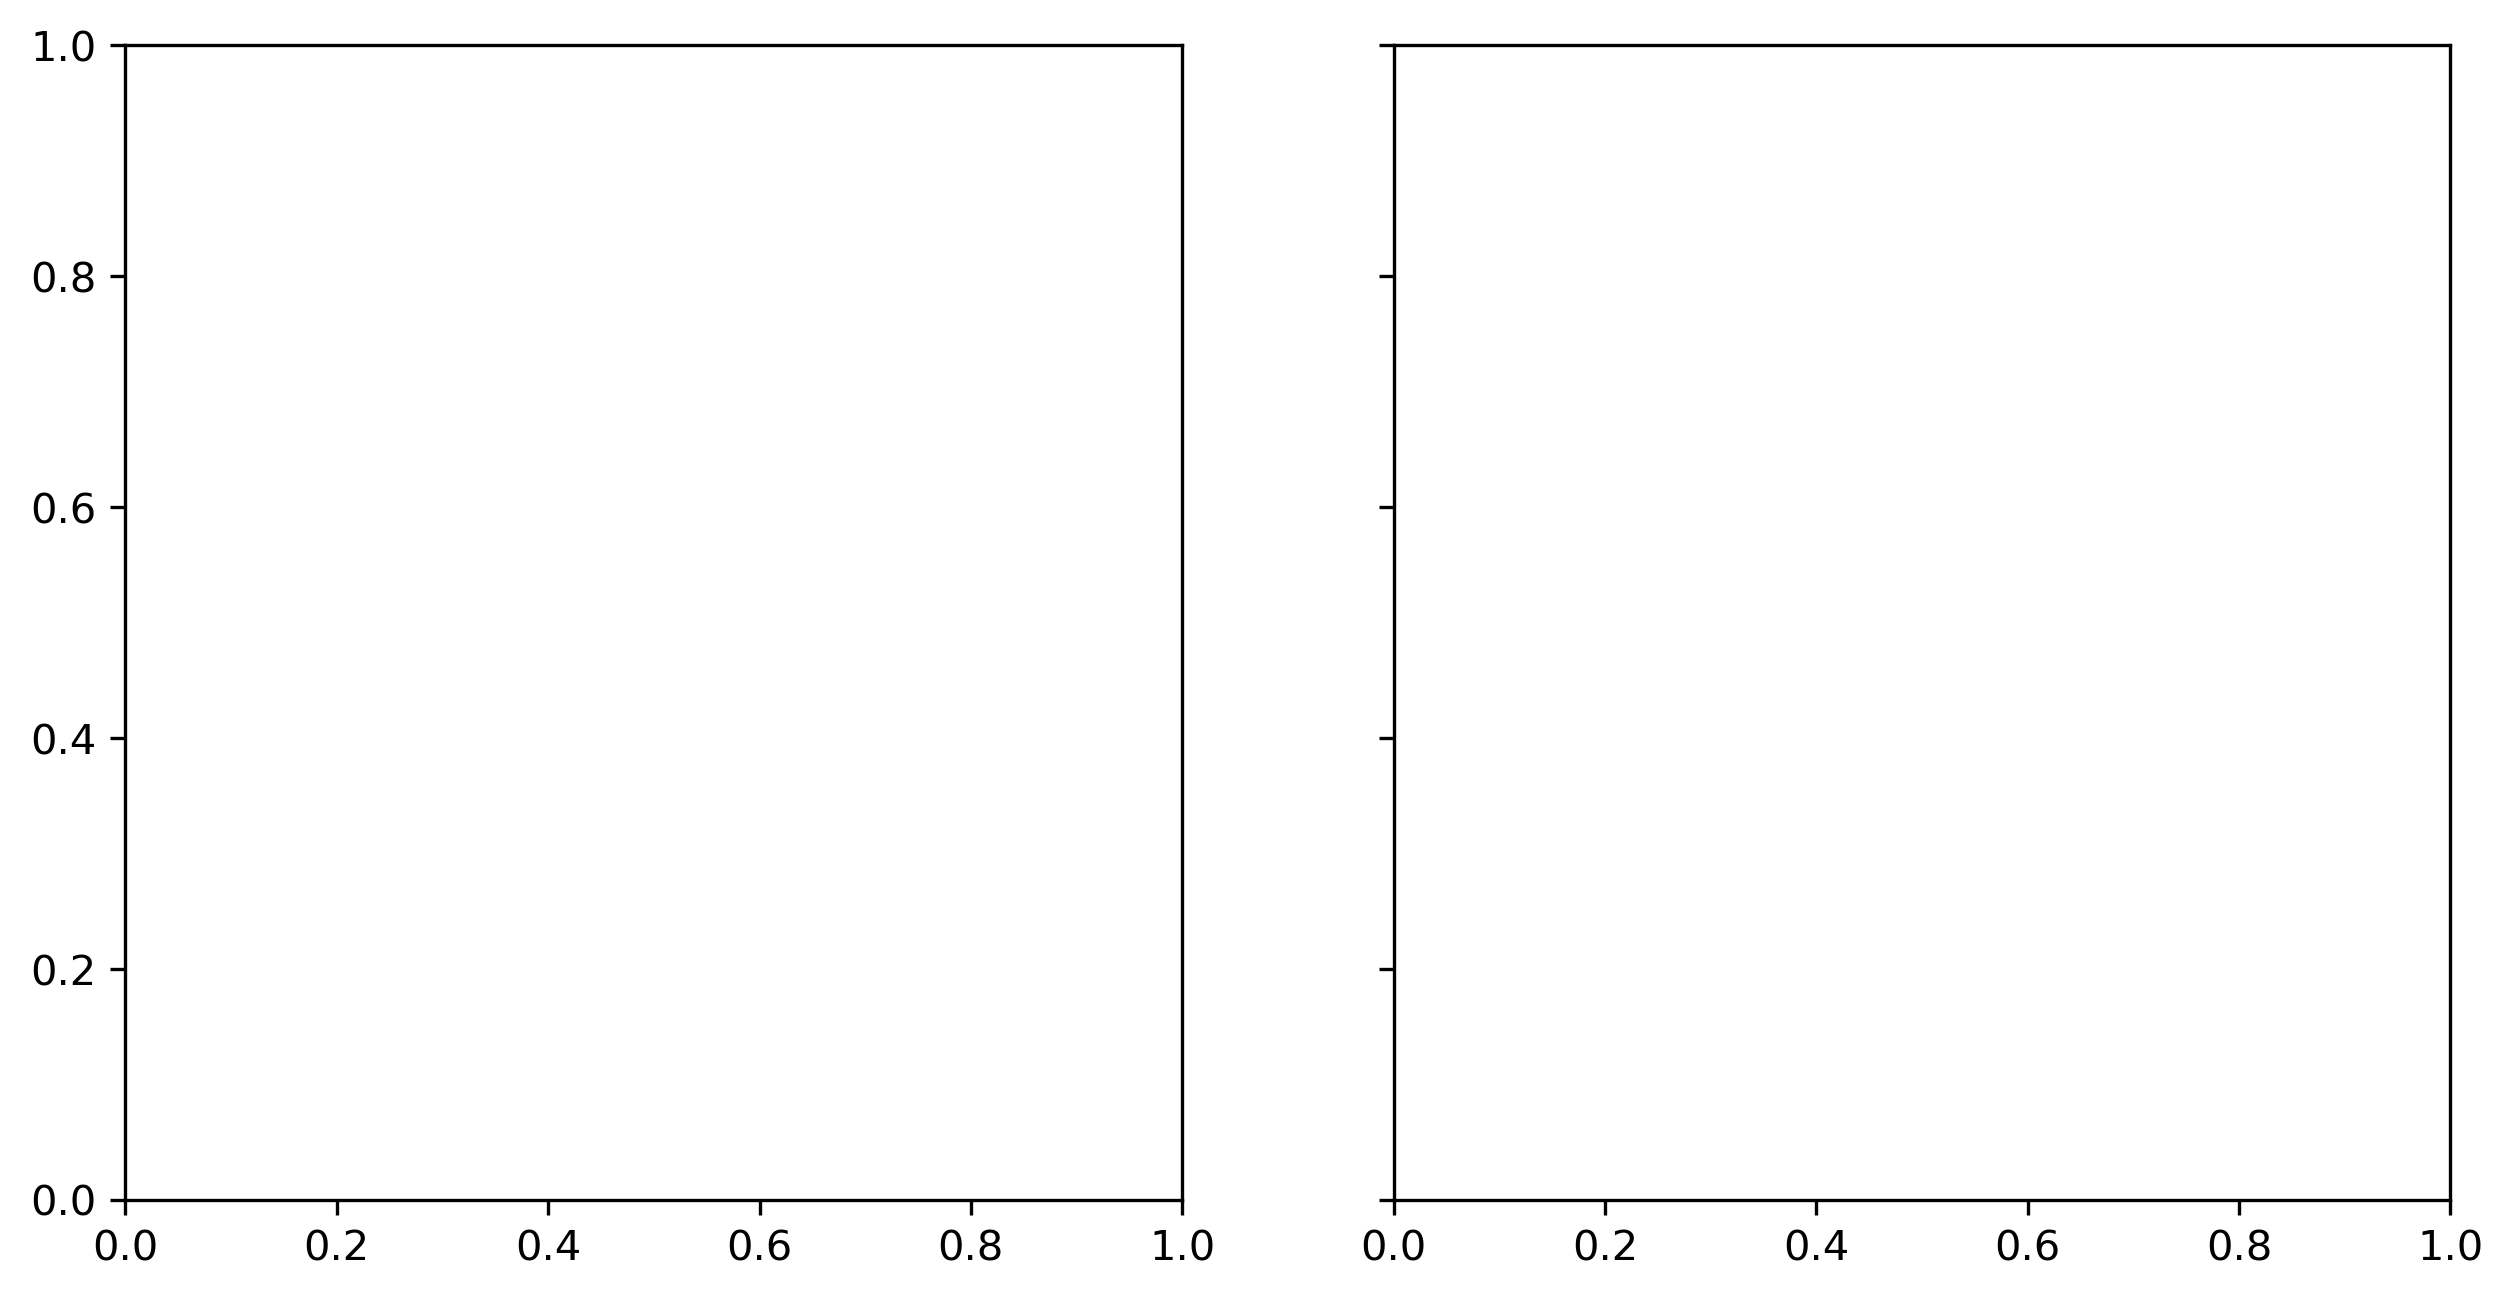

In [ ]:
### plot calcification rates against pH (whether Total or NBS)

# df = df[df['doi'] != '10.1007/s00338-020-01995-7']  # omit doi = 10.1007/s00338-020-01995-7 (crazy error bars)
# scale calcification rates for quick comparison
df['calcification_scaled'] = df.groupby("doi")['calcification'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Compute range for each study
df['calc_range'] = df.groupby("doi")['calcification'].transform(lambda x: x.max() - x.min())

# calculate standard error on mean from standard deviation and sample size
df['se'] = df.apply(lambda row: row['calcification_sd'] / row['n']**0.5 if pd.notnull(row['calcification_sd']) and pd.notnull(row['n']) else np.nan, axis=1)
# update se column with any existing calcification se values
df['se'] = df['se'].combine_first(df['calcification_se'])
# scale standard error using the same factor as calcification rates
# df['se_scaled'] = df['se'] / df['calc_range']
# df['se_scaled'] = df.apply(lambda row: row['se'] / row['calc_range']+0.1 if pd.notnull(row['calc_range']) else np.nan, axis=1)
# define marker size based on sample size
df['n'] = pd.to_numeric(df['n'], errors='coerce')  # Convert to numeric # TODO: account for 'M'
df['marker_size'] = df['n'].apply(lambda x: 10 + 60 * (x / df['n'].max()) if pd.notnull(x) else np.nan)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
unique_dois = df['doi'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))


for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    # pH_df = df[[pH_col, 'calcification_scaled', 'se_scaled', 'marker_size', 'doi']].dropna()
    pH_df = df[[pH_col, 'calcification_scaled', 'se_scaled', 'marker_size', 'doi']]
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['doi'] == doi]
        # ax.errorbar(
        #     doi_df[pH_col], doi_df['calcification_scaled'], yerr=doi_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        # ax.scatter(
        #     doi_df[pH_col], doi_df['calcification_scaled'], s=doi_df['marker_size'], 
        #     color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        # )
        
        ax.scatter(
            doi_df[pH_col], doi_df['calcification_scaled'],
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_dois)//8, fontsize=6, title="doi");

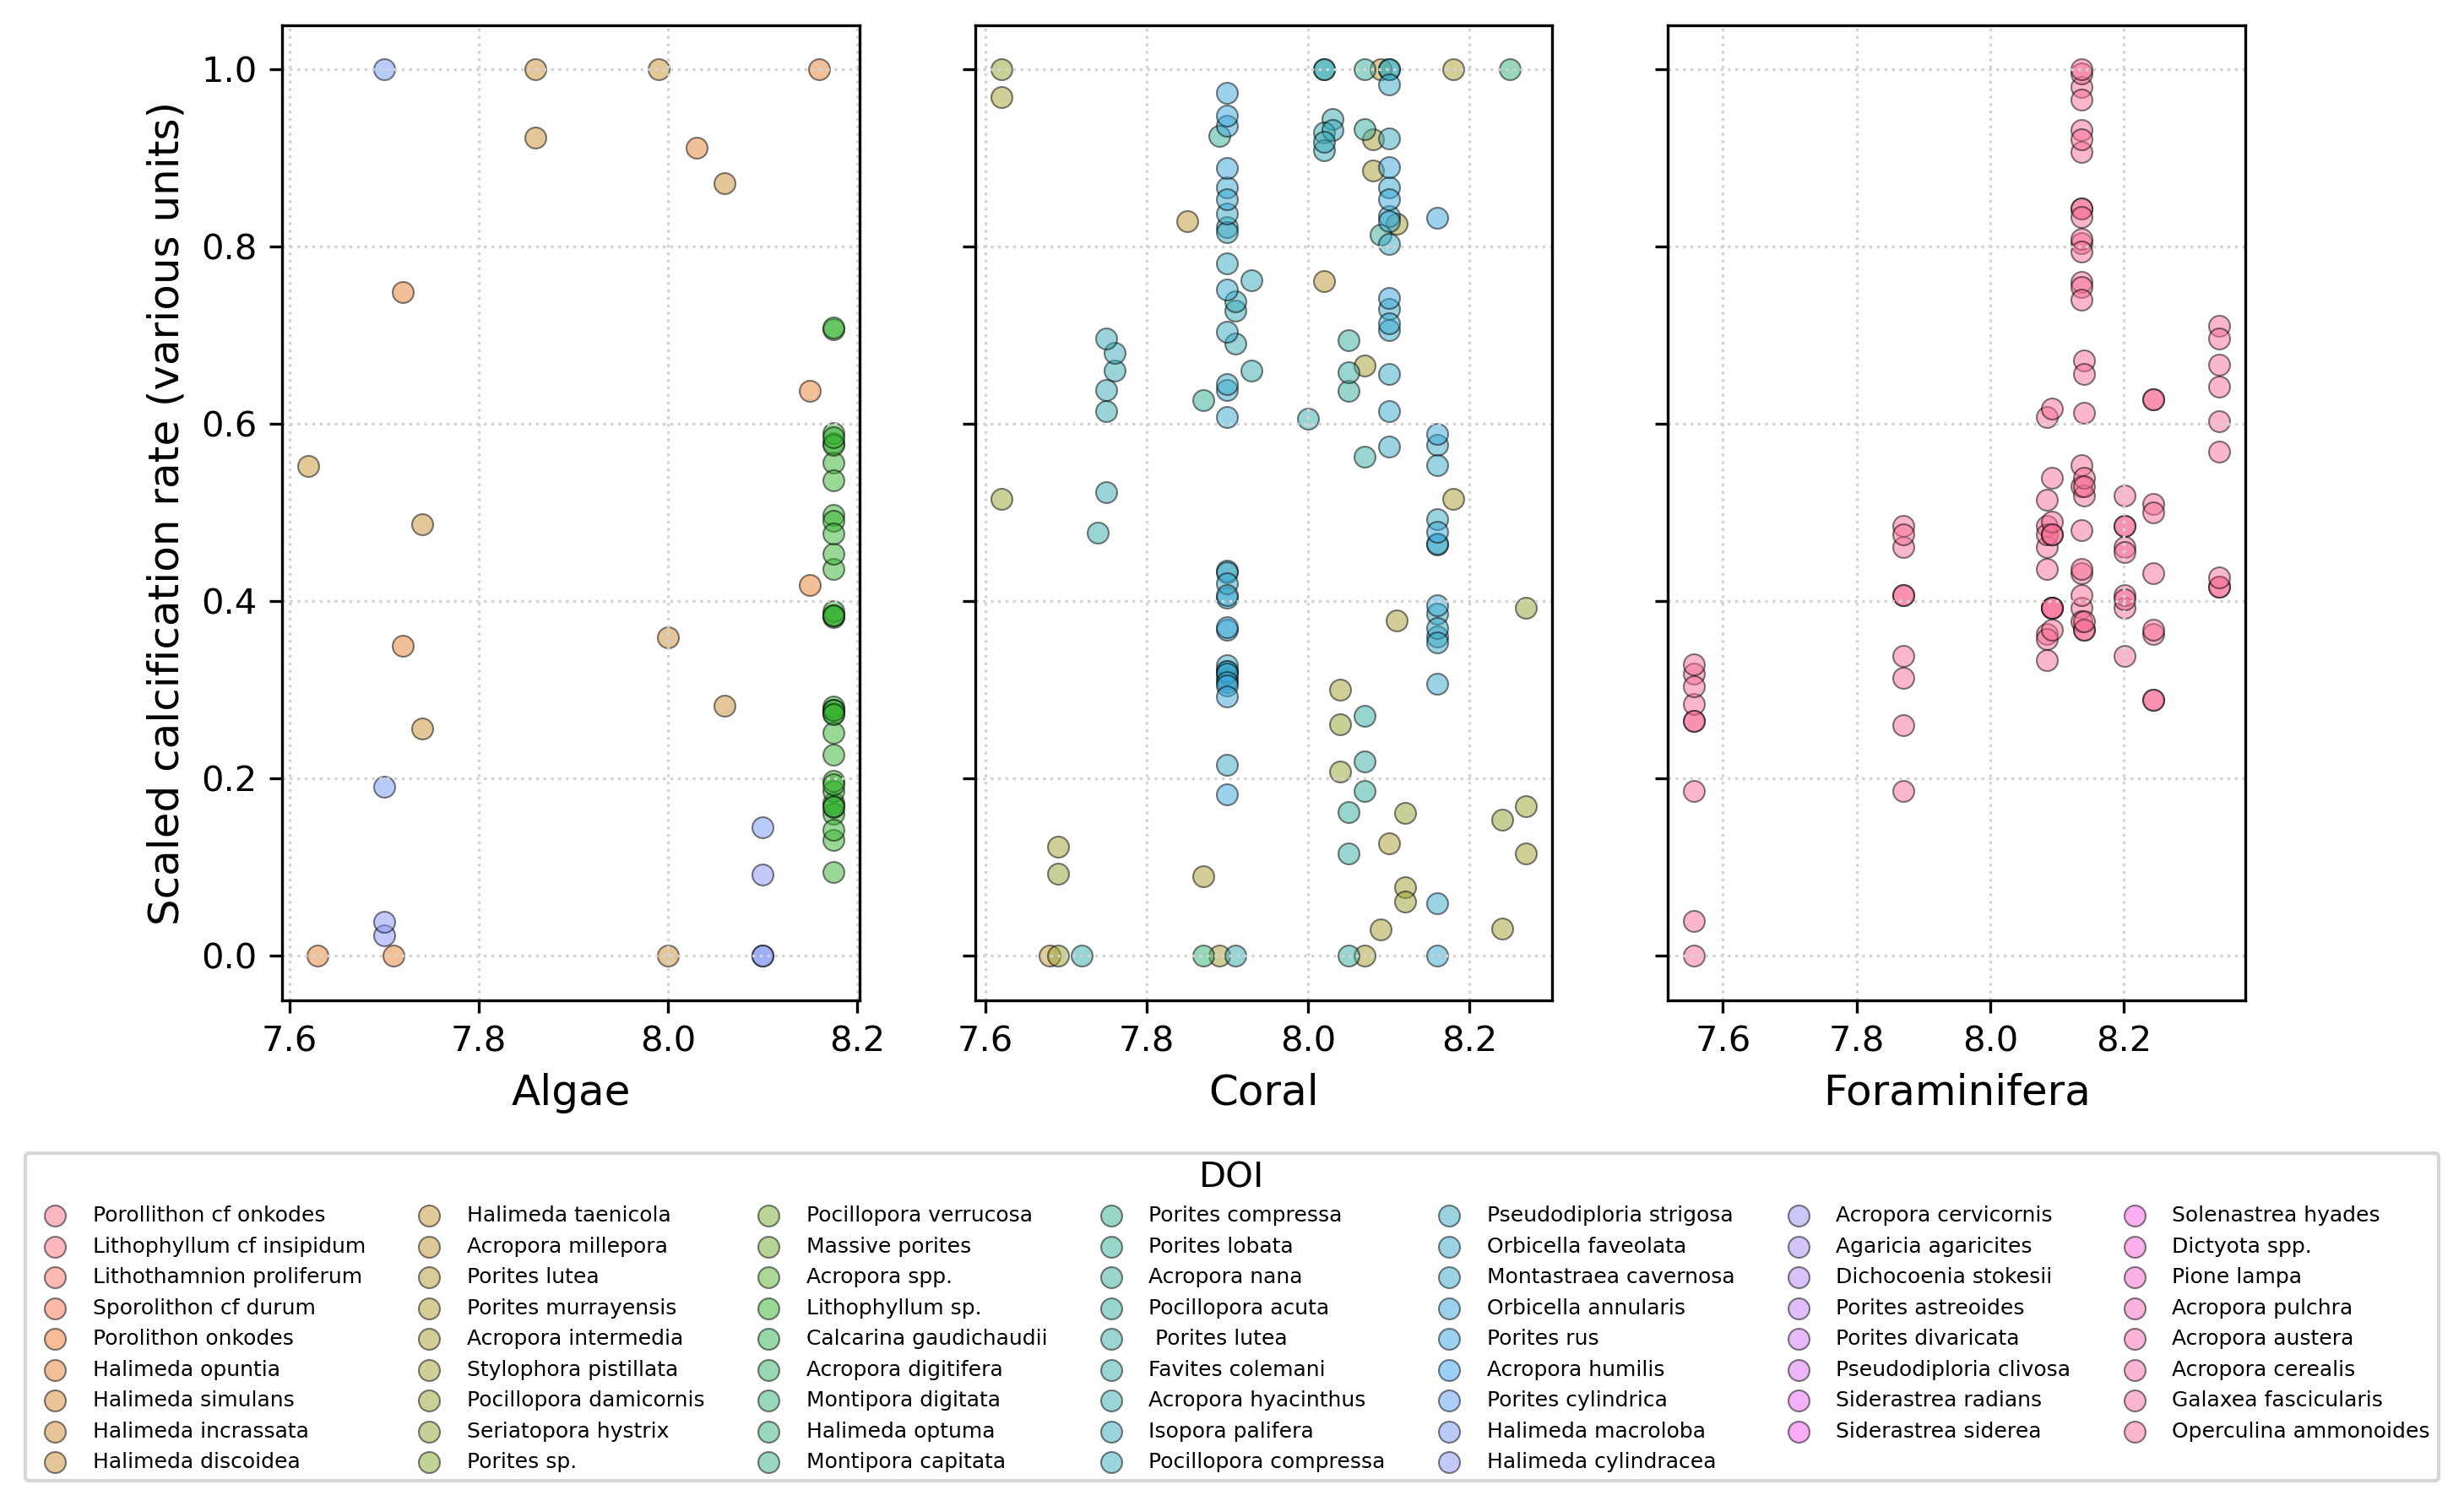

In [ ]:
### plot by taxa

ind_var = 'pH_NBS'
unique_species = df['Species_types'].unique()
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
palette = sns.color_palette("husl", len(unique_species))
species_color_map = dict(zip(unique_species, palette))


for ax, taxa, title in zip(axes, ['Algae', 'Coral', 'Foraminifera'], ['Algae', 'Coral', 'Foraminifera']):
    taxa_df = df[[ind_var, 'Calcification_scaled', 'se_scaled', 'marker_size', 'Species_types']][df['Taxa'] == taxa]
    # drop nas in se_scaled and marker_size
    # taxa_df = taxa_df.dropna(subset=['se_scaled', 'marker_size'])

    
    for species in unique_species:
        species_df = taxa_df[taxa_df['Species_types'] == species]
        # ax.errorbar(
        #     species_df[species], species_df['Calcification_scaled'], yerr=species_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        
        # ax.scatter(
        #     species_df[ind_var], species_df['Calcification_scaled'], s=species_df['marker_size'], 
        #     color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        # )
        
        ax.scatter(
            species_df[ind_var], species_df['Calcification_scaled'],
            color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_species)//8, fontsize=6, title="DOI");

## Investigating fitting methods

To do:
- Send Ben locations
- Convert Ben's R code into Python
- Fix dropping na by sorting out assignment of se
- ~~Linear response vs other?~~     Staying with linear: supportable
- Additionallly incorporate uncertainty in measurement of independent variable
- Measured vs unmeasured
- Standardise rate units + summarise different types
- Mixed effects
- Hierarchical modelling?

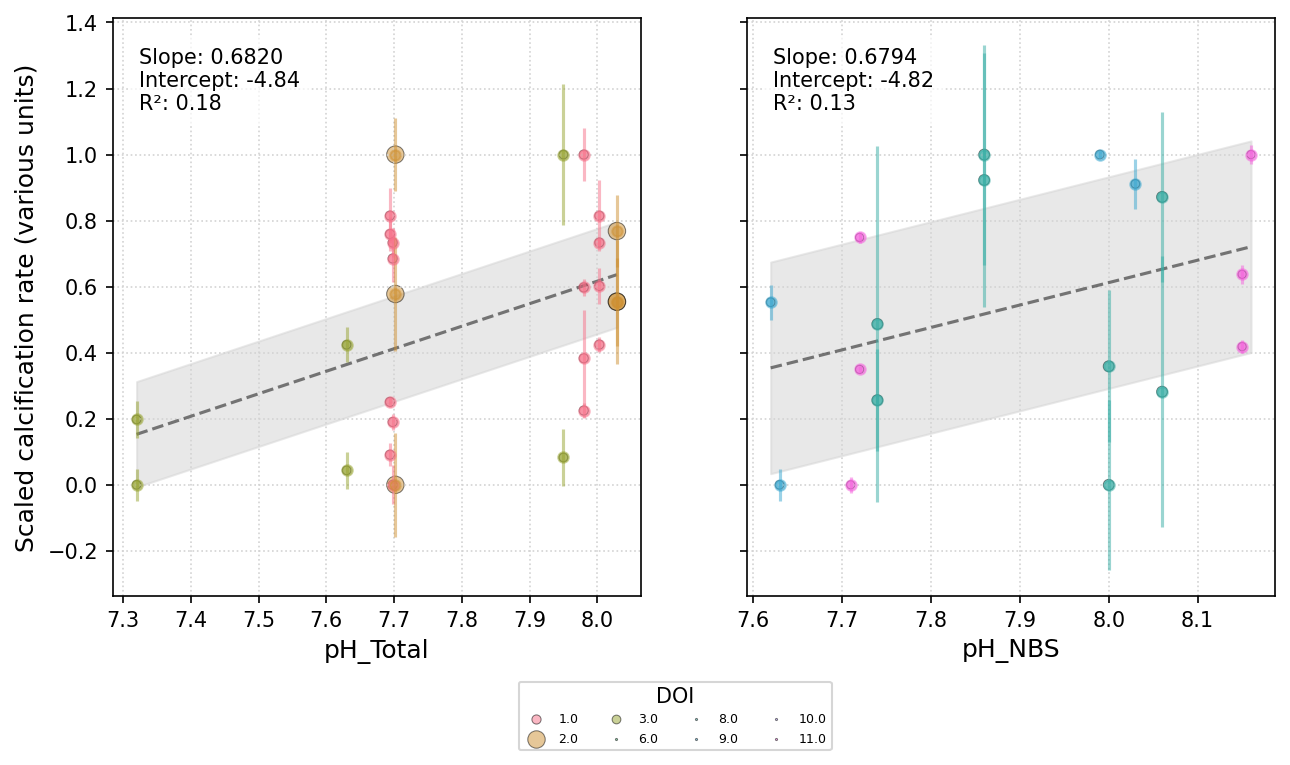

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# generate colour pallete
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

doi_handles, doi_labels = [], []

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    
    # least squares regression
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    m, b = np.polyfit(pH_df[pH_col], pH_df['Calcification_scaled'], 1)
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    # plot regression line
    ax.plot(xs, m*xs + b, color='black', alpha=0.5, linestyle='--')
    # ...and shade uncertainty bounds
    ax.fill_between(xs, m*xs + b - 2*pH_df['se_scaled'].mean(), m*xs + b + 2*pH_df['se_scaled'].mean(), 
                    color='lightgray', alpha=0.5)
    # add info to legend    
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    # add datapoints including error bars
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        scatter = ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5
        )
        
        if doi not in doi_labels:   # add only if not already in legend
            doi_handles.append(scatter)
            doi_labels.append(doi)
    
    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()


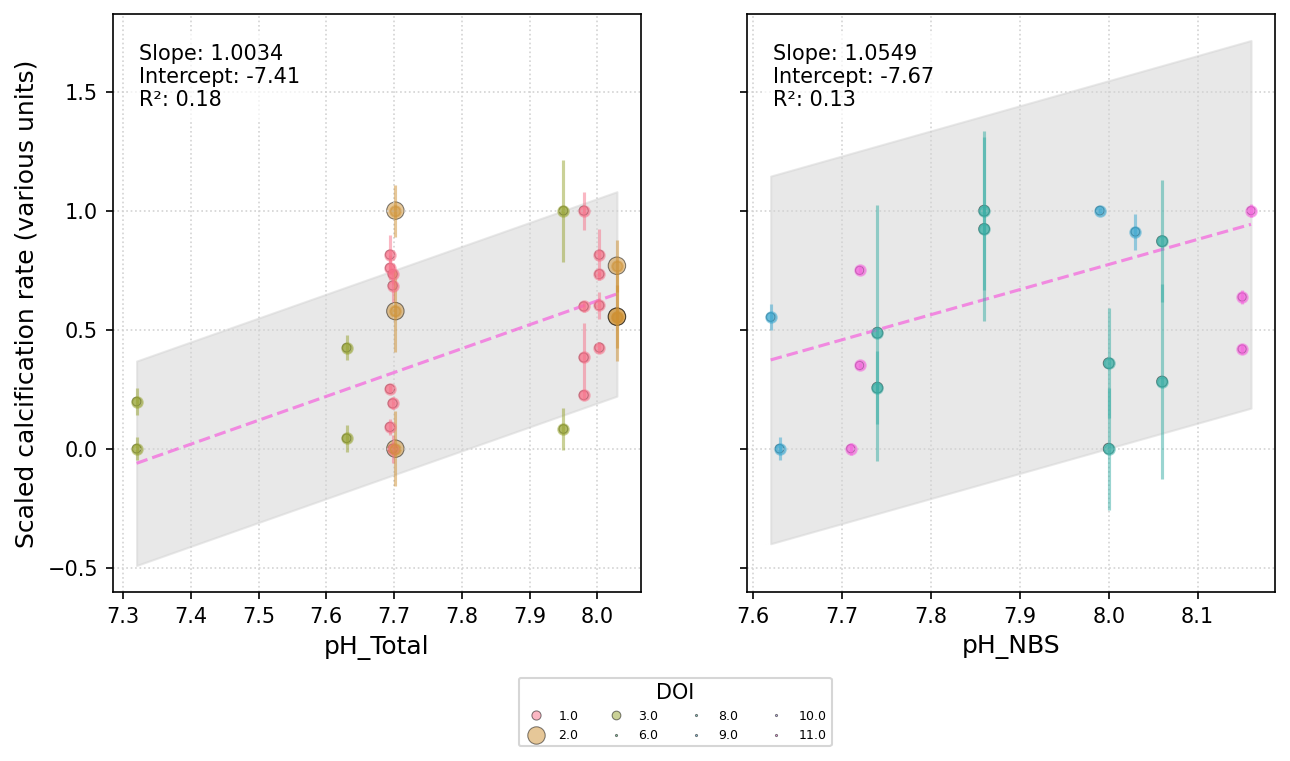

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# Generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()

    # Perform weighted least squares regression (WLS)
    X = sm.add_constant(pH_df[pH_col])  # Add intercept
    y = pH_df['Calcification_scaled']
    weights = 1 / pH_df['se_scaled']**2  # Weight by inverse variance (standard error squared)

    model = sm.WLS(y, X, weights=weights).fit()
    
    # Generate fitted values and confidence intervals
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    Xs = sm.add_constant(xs)  # Add intercept for prediction
    fitted_values = model.predict(Xs)
    
    # get slope and intercept of fitted values
    b, m = model.params
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    
    
    # Add the slope, intercept, and R² to the plot as part of the legend
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    
    # Compute confidence intervals
    predicted_se = np.sqrt(np.diag(model.cov_params()))  # Standard errors of the coefficients
    confidence_interval = 1.96 * predicted_se[1]  # 95% confidence interval for slope (use the second coefficient)
    
    # Plot the fitted regression line and confidence interval
    ax.plot(xs, fitted_values, color=doi_color_map[doi], alpha=0.7, linestyle='--')
    ax.fill_between(xs, fitted_values - confidence_interval, fitted_values + confidence_interval,
                    color='lightgray', alpha=0.5)
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")
    
    if doi not in doi_labels:   # add only if not already in legend
        doi_handles.append(scatter)
        doi_labels.append(doi)

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# Add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()
# N.B. accounting for uncertainty in measured values makes a major difference: compare the slopes

### Work in progress

In [ ]:
import statsmodels.api as sm

pH_col = 'pH_Total'
pH_df = df.dropna(subset=[pH_col, 'Calcification_scaled', 'se_scaled'])

X = sm.add_constant(pH_df[pH_col])  # add constant (intercept) term
y = pH_df['Calcification_scaled']   # dependent variable (response)

weights = 1 / 10*pH_df['se_scaled']**2  # calculate the weights (inverse of the squared standard errors). N.B. 10 is a heuristic scaling factor to prevent weight explosion
# adjust X and y for the weights (multiply by sqrt(weights))
X_weighted = X * np.sqrt(np.array(weights))[:, np.newaxis]
y_weighted = y * np.sqrt(np.array(weights))

model = sm.GLS(y_weighted, X_weighted).fit()
print(f"Results for {pH_col}:")
print(model.summary())

Results for pH_Total:
                                  GLS Regression Results                                 
Dep. Variable:     Calcification_scaled   R-squared (uncentered):                   0.779
Model:                              GLS   Adj. R-squared (uncentered):              0.764
Method:                   Least Squares   F-statistic:                              52.87
Date:                  Wed, 12 Feb 2025   Prob (F-statistic):                    1.47e-10
Time:                          01:00:40   Log-Likelihood:                          102.07
No. Observations:                    32   AIC:                                     -200.1
Df Residuals:                        30   BIC:                                     -197.2
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_68091/2698863054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pH_df.loc[:, 'fitted_values'] = model.fittedvalues


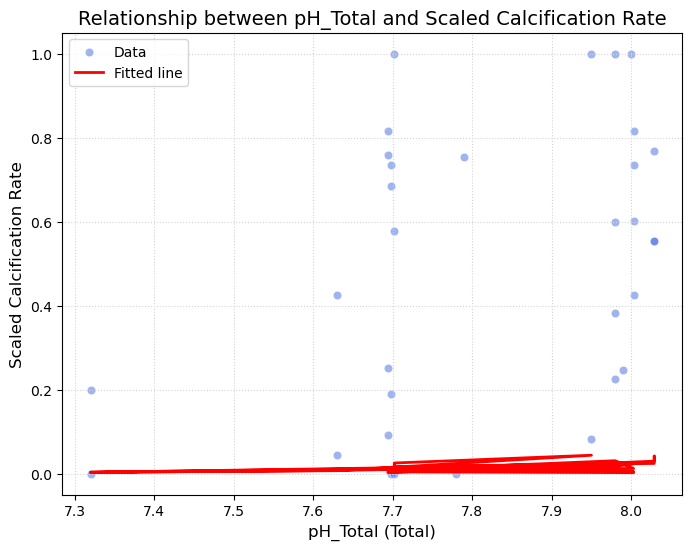

In [ ]:
# Get the fitted values
pH_df.loc[:, 'fitted_values'] = model.fittedvalues

# Plotting the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pH_df[pH_col], y=pH_df['Calcification_scaled'], color='royalblue', alpha=0.5, label='Data')

# Plot the regression line (fitted values)
plt.plot(pH_df[pH_col], pH_df['fitted_values'], color='red', label='Fitted line', linewidth=2)

# Calculate the standard errors of the fitted values
predicted_se = np.sqrt(np.diag(model.cov_params()))

# Confidence interval (95%)
confidence_interval = 1.96 * predicted_se

# # Calculate the upper and lower bounds for the fitted values
# upper_bound = pH_df['fitted_values'] + confidence_interval
# lower_bound = pH_df['fitted_values'] - confidence_interval

# # Plot the confidence intervals as a shaded region
# plt.fill_between(pH_df[pH_col], lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Add labels and title
plt.xlabel(f'{pH_col} (Total)', fontsize=12)
plt.ylabel('Scaled Calcification Rate', fontsize=12)
plt.title(f'Relationship between {pH_col} and Scaled Calcification Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', color='lightgrey')

# Show the plot
plt.show()